# Project Section Outline
A bit cleaner than just using comments

### Import dependencies
- from census import Census
- pandas as pd
- matplotlib.pyplot as plt
- from us import states
- os
- config file keys

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from census import Census
from us import states
from jmp_config import g_key
from jmp_config import census_key

### Import and clean CA crime data
- Get data from CSV file
- Clean up the county names
- Find only data for crimes with firearms
- Save a separate dataframe

In [2]:
#Set path for crime data from California
filepath = os.path.join('Data','Crimes_and_Clearances_with_Arson-1985-2019.csv')
df = pd.read_csv(filepath, low_memory=False)
#Remove 'county' from the County name field
df['County']=df['County'].str.replace(' County','')
#Remove unneeded fields.  
#'FROBact_sum' is total robberies with a firearm, actual offenses
#'FASSact_sum' is total assault with a firearm, actual offenses
df_clean=df[['Year','County','NCICCode','Violent_sum','FROBact_sum','FASSact_sum']]
#clean up column names
df_clean=df_clean.rename(columns={'FROBact_sum':'firearmRobberySum',
                                 'FASSact_sum':'firearmAssaultSum',
                                 'Violent_sum':'violentSum'})
df_clean['firearmTotal']=df_clean['firearmRobberySum']+df_clean['firearmAssaultSum']
df_clean.head()

,Year,County,NCICCode,violentSum,firearmRobberySum,firearmAssaultSum,firearmTotal
0,1985,Alameda,Alameda Co. Sheriff's Department,427,77,25,102
1,1985,Alameda,Alameda,405,56,16,72
2,1985,Alameda,Albany,101,23,3,26
3,1985,Alameda,Berkeley,1164,242,47,289
4,1985,Alameda,Emeryville,146,35,6,41


### Import and clean Census data
- Get data from census API (2009 through 2019 is what is available)
- Get population data for CA
- Bonus: get population data for each county (may not be available)
- Save data as a simple dataframe (year, population)

In [4]:
#Set up a dataframe with a call to the census API for 2009 county population data
year=2009
c=Census(census_key, year=year)
census_data = c.acs5.get(('NAME','B01003_001E'), geo={'for': 'county:*',
                       'in': 'state:{}'.format(states.CA.fips)})
# Save as dataframe
CAPop_df = pd.DataFrame(census_data)

# Rename columns
CAPop_df = CAPop_df.rename(columns={"B01003_001E": "Population",
                                    "county":'countyNo',
                                    "state":'stateNo'})
#Add a column that only has the county name
CAPop_df['County']=CAPop_df['NAME'].str.replace(' County, California','')

#Add a year column
CAPop_df['Year']= year



#Set up a loop to get the rest of the data for years 2010-2019
for year in range(2010,2020):
    
    c=Census(census_key, year=year)
    census_data = c.acs5.get(('NAME','B01003_001E'), geo={'for': 'county:*',
                       'in': 'state:{}'.format(states.CA.fips)})

    # Save as dataframe
    census_pd = pd.DataFrame(census_data)

    # Rename columns
    census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                    "county":'countyNo',
                                    "state":'stateNo'})
    #Add a column that only has the county name
    census_pd['County']=census_pd['NAME'].str.replace(' County, California','')
    
    #Add a year column
    census_pd['Year']=year
    
    # Append the existing CAPop_df dataframe with the results from the current iteration
    CAPop_df=CAPop_df.append(census_pd,ignore_index=True)

CAPop_df.head()
CAPop_df.to_csv('Data/CA_CountyPop_2009to2019.csv')

### Group crime data
- Group by year
- Get total gun crimes per year
- Get total gun crimes per 100,000 people
- Bonus: group by county (if county population data is available)
- Bonus: get gun crimes per county
- Bonus: get gun crimes per 100,000 people in a county

In [8]:
#Total gun crimes in CA by year
gunCrime = df_clean.loc[df_clean['Year']>=2009]
gunYears=gunCrime.groupby('Year')
gunCrimeByYear=gunYears['firearmTotal'].sum()

#CA population by year
CAyears=CAPop_df.groupby('Year')
CAPopByYear = CAyears['Population'].sum()
CAPopByYear

#Combine groupby series
CAGunsYears = pd.concat([gunCrimeByYear,CAPopByYear],axis=1).reset_index()
CAGunsYears = CAGunsYears.rename(columns={
    'firearmTotal':'TotalGunCrimes'
})

#Calculate the number of gun crimes per 100,000 people for each year
CAGunsYears['GunCrimesPer100k']=round((CAGunsYears['TotalGunCrimes']/CAGunsYears['Population'])*100000,2)

CAGunsYears

,Year,TotalGunCrimes,Population,GunCrimesPer100k
0,2009,37196,36308527.0,102.44
1,2010,35047,36637290.0,95.66
2,2011,33344,36969200.0,90.19
3,2012,35123,37325068.0,94.10
4,2013,31884,37659181.0,84.66
5,2014,29347,38066920.0,77.09
6,2015,32992,38421464.0,85.87
7,2016,36123,38654206.0,93.45
8,2017,34506,38982847.0,88.52
9,2018,31409,39148760.0,80.23


In [16]:
#Total gun crimes by county by year
gunYearsCounty = gunCrime.groupby(['Year','County'])
gunCrimeByCountyYear=gunYearsCounty['firearmTotal'].sum()
gunCrimeByCountyYear

#CA population by year
CAyearsCounty=CAPop_df.groupby(['Year','County'])
CAPopByYearCounty = CAyearsCounty['Population'].sum()
CAPopByYearCounty

#Combine groupby series
CAGunsYearsCounty = pd.concat([gunCrimeByCountyYear,CAPopByYearCounty],axis=1).reset_index()
CAGunsYearsCounty = CAGunsYearsCounty.rename(columns={
    'firearmTotal':'TotalGunCrimes'
})

#Calculate the number of gun crimes per 100,000 people for each year
CAGunsYearsCounty['GunCrimesPer100k']=round((CAGunsYearsCounty['TotalGunCrimes']/CAGunsYearsCounty['Population'])*100000,2)

LAGunsYears = CAGunsYearsCounty.loc[CAGunsYearsCounty['County']=='Los Angeles']
LAGunsYears

,Year,County,TotalGunCrimes,Population,GunCrimesPer100k
18,2009,Los Angeles,15113,9785295.0,154.45
76,2010,Los Angeles,12908,9758256.0,132.28
134,2011,Los Angeles,11277,9787747.0,115.22
192,2012,Los Angeles,10657,9840024.0,108.30
250,2013,Los Angeles,9432,9893481.0,95.34
308,2014,Los Angeles,9103,9974203.0,91.27
366,2015,Los Angeles,11332,10038388.0,112.89
424,2016,Los Angeles,13446,10057155.0,133.70
482,2017,Los Angeles,12872,10105722.0,127.37
540,2018,Los Angeles,11804,10098052.0,116.89


### Plot gun crime data
- Bar chart of gun crimes per year
- Bar chart of gun crimes per year per capita
- Bonus: bar chart of gun crimes per year in LA County
- Bonus: bar chart of gun crimes per year in LA County per capita
- Save your charts to files

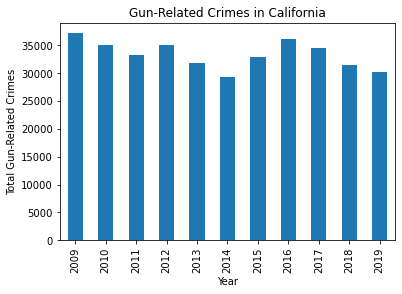

In [20]:
#Bar chart of CA gun grimes per year
gunCrimeByYear.plot(kind="bar")
plt.ylabel('Total Gun-Related Crimes')
plt.title('Gun-Related Crimes in California')
plt.show()

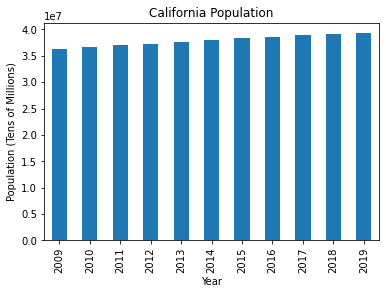

In [24]:
#Bar Chart of CA population per year
CAPopByYear.plot(kind="bar")
plt.ylabel("Population (Tens of Millions)")
plt.title("California Population")
plt.show()

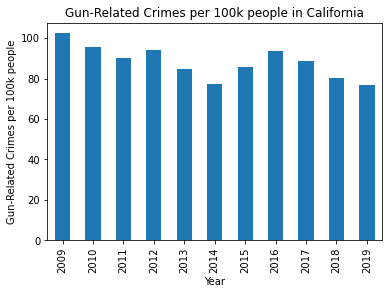

In [34]:
#Bar Chart of gun crimes per capita in CA
CAGunsPerCapita = CAGunsYears[['Year','GunCrimesPer100k']]
CAGunsPerCapita = CAGunsPerCapita.set_index('Year')
CAGunsPerCapita.plot(kind='bar', legend=False)
plt.ylabel('Gun-Related Crimes per 100k people')
plt.title('Gun-Related Crimes per 100k people in California')
plt.show()

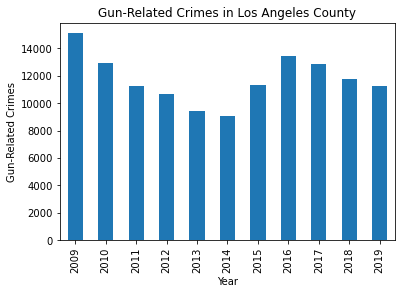

In [35]:
#Bar Chart of gun crimes per year in LA County
LAGunCrime = LAGunsYears[['Year','TotalGunCrimes']]
LAGunCrime = LAGunCrime.set_index('Year')
LAGunCrime.plot(kind='bar', legend=False)
plt.ylabel('Gun-Related Crimes')
plt.title('Gun-Related Crimes in Los Angeles County')
plt.show()

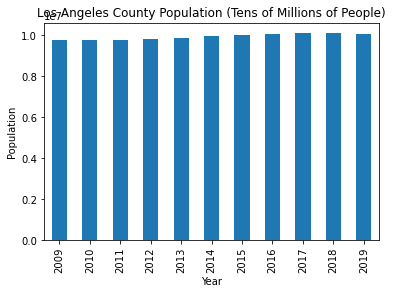

In [37]:
#Bar Chart of population in LA County
LAPop = LAGunsYears[['Year','Population']]
LAPop = LAPop.set_index('Year')
LAPop.plot(kind='bar', legend=False)
plt.ylabel('Population')
plt.title('Los Angeles County Population (Tens of Millions of People)')
plt.show()

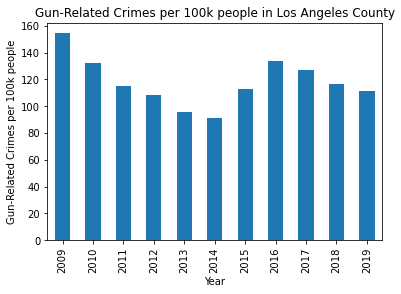

In [38]:
#Bar Chart of gun crimes per 100k people in LA County
LAGunCrimePC = LAGunsYears[['Year','GunCrimesPer100k']]
LAGunCrimePC = LAGunCrimePC.set_index('Year')
LAGunCrimePC.plot(kind='bar', legend=False)
plt.ylabel('Gun-Related Crimes per 100k people')
plt.title('Gun-Related Crimes per 100k people in Los Angeles County')
plt.show()

In [46]:
CAGunsYearsCounty.tail(60)

,Year,County,TotalGunCrimes,Population,GunCrimesPer100k
578,2018,Yolo,73,214977.0,33.96
579,2018,Yuba,28,75493.0,37.09
580,2019,Alameda,2577,1656754.0,155.55
581,2019,Alpine,0,1039.0,0.00
582,2019,Amador,7,38429.0,18.22
583,2019,Butte,121,225817.0,53.58
584,2019,Calaveras,22,45514.0,48.34
585,2019,Colusa,4,21454.0,18.64
586,2019,Contra Costa,888,1142251.0,77.74
587,2019,Del Norte,3,27495.0,10.91


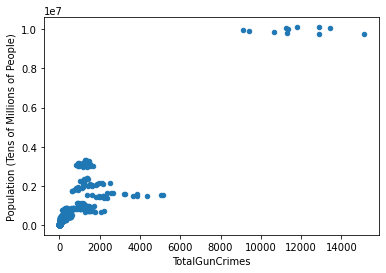

In [42]:
CAGunsPop = CAGunsYearsCounty[['TotalGunCrimes','Population']]
CAGunsPop.plot(kind='scatter',x="TotalGunCrimes",y='Population')
plt.ylabel('Population (Tens of Millions of People)')
plt.show()